# Reconocimiento de la actividad humana usando datos del smartphone

El objetivo de este análisis es construir un modelo que nos permita basado en los datos de los sensores de un smartphone de Samsung reconocer que actividad esta realizando una persona.


# Instalar los packages necesarios 

In [1]:
if(!require(car)){
    install.packages('car',repos='http://cran.es.r-project.org')
    require(car)
}
if(!require(C50)){
    install.packages('C50',repos='http://cran.es.r-project.org')
    require(C50)
}
if(!require(gmodels)){
    install.packages('gmodels',repos='http://cran.es.r-project.org')
    require(gmodels)
}
if(!require(randomForest)){
    install.packages('randomForest',repos='http://cran.es.r-project.org')
    require(randomForest)
}
if(!require(e1071)){
    install.packages('e1071',repos='http://cran.es.r-project.org')
    require(e1071)
}
if(!require(mlbench)){
    install.packages('v',repos='http://cran.es.r-project.org')
    require(mlbench)
}
if(!require(caret)){
    install.packages('v',repos='http://cran.es.r-project.org')
    require(caret)
}
if(!require(mlbench)){
    install.packages('v',repos='http://cran.es.r-project.org')
    require(mlbench)
}
if(!require(caTools)){
    install.packages('v',repos='http://cran.es.r-project.org')
    require(caTools)
}


Loading required package: car
Loading required package: C50
Warning message:
"package 'C50' was built under R version 3.3.2"Loading required package: gmodels
Warning message:
"package 'gmodels' was built under R version 3.3.2"Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.3.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: e1071
Warning message:
"package 'e1071' was built under R version 3.3.2"Loading required package: mlbench
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Loading required package: caTools


# Leer datos del repositorio público

Nos basaremos en los datos generados por Anguita et al que están disponibles en el repositorio UCI de Machine Learning [1]. 

El archivo está comprimido y ocupa 58 Megabytes. Los datos incluidos fueron generados con un grupo de 30 voluntarios entre 19 y 48 años. Cada persona realizó seis actividades: caminar (WALKING), caminar escaleras arriba (WALKING_UPSTAIRS), caminar escaleras abajo (WALKING_DOWNSTAIRS), estar sentado (SITTING), estar de pie (STANDING) y estar yacer (LAYING) llevando un smartphone Samsung Galaxy SII en la muñeca. Con ayuda del acelerómetro y giroscopio del teléfono se capturaron la aceleración lineal y la velocidad angular en los tres ejes. Las actividades realizadas se etiquetaron manualmente. Más información en [1].      

[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. International Workshop of Ambient Assisted Living (IWAAL 2012). Spain. Dec 2012.
http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

# Seleccionar subset de datos para modelar

Una vez bajados los datos se procedió a descomprimirlos. El archivo descomprimido incluye dos directorios: train y test. 
En el presente proyecto trabajaremos solamente con datos del set train. 

Antes de ejecutar el siguiente código se debe actualizar el directorio donde se han descomprimido los archivos. En nuestro caso UCI_HAR_Dataset

In [2]:
x <- read.table(file='UCI_HAR_Dataset/train/X_train.txt')
y <- read.table(file='UCI_HAR_Dataset/train/y_train.txt')
subject <- read.table(file='UCI_HAR_Dataset/train/subject_train.txt')
activity_labels <- read.table(file='UCI_HAR_Dataset/activity_labels.txt')
features <- read.table(file='UCI_HAR_Dataset/features.txt')

# Inspeccionar el conjunto de datos 

In [3]:
dim(x)
dim(y)


[1] 7352  561

[1] 7352    1

In [4]:
head(x)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561
1,0.28858451,-0.020294171,-0.13290514,-0.9952786,-0.98311061,-0.91352645,-0.99511208,-0.98318457,-0.92352702,-0.93472378,...,-0.074323027,-0.29867637,-0.71030407,-0.11275434,0.030400372,-0.46476139,-0.018445884,-0.84124676,0.17994061,-0.058626924
2,0.27841883,-0.016410568,-0.12352019,-0.99824528,-0.97530022,-0.96032199,-0.99880719,-0.97491437,-0.95768622,-0.94306751,...,0.15807454,-0.59505094,-0.86149931,0.053476955,-0.0074345661,-0.73262621,0.70351059,-0.8447876,0.18028889,-0.054316717
3,0.27965306,-0.019467156,-0.11346169,-0.99537956,-0.96718701,-0.97894396,-0.99651994,-0.96366837,-0.97746859,-0.93869155,...,0.41450281,-0.39074815,-0.76010372,-0.11855926,0.17789948,0.10069921,0.80852908,-0.84893347,0.18063731,-0.049117815
4,0.27917394,-0.026200646,-0.12328257,-0.99609149,-0.9834027,-0.9906751,-0.99709947,-0.98274984,-0.9893025,-0.93869155,...,0.40457253,-0.1172902,-0.48284451,-0.036787973,-0.012892494,0.64001104,-0.48536645,-0.84864938,0.18193476,-0.047663183
5,0.27662877,-0.016569655,-0.11536185,-0.99813862,-0.98081727,-0.99048163,-0.99832113,-0.97967187,-0.99044113,-0.94246912,...,0.087753013,-0.35147093,-0.69920515,0.12332005,0.12254196,0.69357829,-0.61597061,-0.84786525,0.18515116,-0.043892254
6,0.27719877,-0.01009785,-0.10513725,-0.99733496,-0.99048681,-0.99542003,-0.9976274,-0.99021769,-0.9955489,-0.94246912,...,0.01995331,-0.54541011,-0.8446193,0.082632155,-0.14343901,0.27504075,-0.36822404,-0.84963158,0.18482251,-0.042126383


Son en total 7352 observaciones con 561 variables de entrada.
Inspeccionamos ahora si hay valores no informados:

In [5]:
sapply (x, function(x)(sum(is.na(x))))

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 V97  V98  V99 V100 V101 V102 V103 V104 V105 V106 V107 V108 V109 V110 V111 V112 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V113 V114 V115 V116 V117 V118 V119 V120 V121 V122 V123 V124 V125 V126 V127 V128 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V129 V130 V131 V132 V133 V134 V135 V136 V137 V138 V139 V140 V141 V142 V143 V144 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V145 V146 V147 V148 V149 V150 V151 V152 V153 V154 V155 V156 V157 V158 V159 V160 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V161 V162 V163 V164 V165 V166 V167 V168 V169 V170 V171 V172 V173 V174 V175 V176 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V177 V178 V179 V180 V181 V182 V183 V184 V185 V186 V187 V188 V189 V190 V191 V192 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V193 V194 V195 V196 V197 V198 V199 V200 V201 V202 V203 V204 V205 V206 V207 V208 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V209 V210 V211 V212 V213 V214 V215 V216 V217 V218 V219 V220 V221 V222 V223 V224 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V225 V226 V227 V228 V229 V230 V231 V232 V233 V234 V235 V236 V237 V238 V239 V240 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V241 V242 V243 V244 V245 V246 V247 V248 V249 V250 V251 V252 V253 V254 V255 V256 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V257 V258 V259 V260 V261 V262 V263 V264 V265 V266 V267 V268 V269 V270 V271 V272 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V273 V274 V275 V276 V277 V278 V279 V280 V281 V282 V283 V284 V285 V286 V287 V288 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V289 V290 V291 V292 V293 V294 V295 V296 V297 V298 V299 V300 V301 V302 V303 V304 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V305 V306 V307 V308 V309 V310 V311 V312 V313 V314 V315 V316 V317 V318 V319 V320 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V321 V322 V323 V324 V325 V326 V327 V328 V329 V330 V331 V332 V333 V334 V335 V336 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V337 V338 V339 V340 V341 V342 V343 V344 V345 V346 V347 V348 V349 V350 V351 V352 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V353 V354 V355 V356 V357 V358 V359 V360 V361 V362 V363 V364 V365 V366 V367 V368 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V369 V370 V371 V372 V373 V374 V375 V376 V377 V378 V379 V380 V381 V382 V383 V384 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
V385 V386 V387 V388 V389 V390 V391 V392 V393 V394 V395 V396 V397 V398 V399 V400 
   0    0    0    0    0    0    

No hay valores nulos en nuestros datos.

Para inspeccionar los datos más facilmente hemos decidido incluir la actividad realizada y  el sujeto o persona que realizó la actividad entre las variables de x:

In [6]:
x$activity <- factor(y$V1,levels=activity_labels[,1],labels=activity_labels[,2])
x$subject <- factor(subject$V1)

Ahora inspeccionemos un poco los datos:

In [7]:
length(unique(x$subject))

[1] 21

Tenemos observaciones correspondientes a 21 personas.

In [8]:
table(x$subject)


  1   3   5   6   7   8  11  14  15  16  17  19  21  22  23  25  26  27  28  29 
347 341 302 325 308 281 316 323 328 366 368 360 408 321 372 409 392 376 382 344 
 30 
383 

El número de observaciones para cada persona varía. El sujeto con más observaciones es el número 25 con 409 y el con menos el número 5 con 302.

In [9]:
table(x$activity)


           WALKING   WALKING_UPSTAIRS WALKING_DOWNSTAIRS            SITTING 
              1226               1073                986               1286 
          STANDING             LAYING 
              1374               1407 

las actividades tampoco están homogeneamente distribuidas. La actividad con más observaciones es LAYING y la con menos WALKING_DOWNSTAIRS.

In [10]:
table(x$subject,x$activity)

    
     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING STANDING LAYING
  1       95               53                 49      47       53     50
  3       58               59                 49      52       61     62
  5       56               47                 47      44       56     52
  6       57               51                 48      55       57     57
  7       57               51                 47      48       53     52
  8       48               41                 38      46       54     54
  11      59               54                 46      53       47     57
  14      59               54                 45      54       60     51
  15      54               48                 42      59       53     72
  16      51               51                 47      69       78     70
  17      61               48                 46      64       78     71
  19      52               40                 39      73       73     83
  21      52               47                 

Vemos que todos los sujetos han realizados todas las actividades aunque la distribución no es homogénea: no todas las personas tienen el mismo número de observaciones para cada actividad.


# Eliminar variables redundantes

Haciendo uso de la correlación eliminaremos ahora variables que esten muy correlacionadas:  

In [11]:
library (mlbench)
library (caret)
correlacionMatrix <- cor (x[,1:561])
MaxCorrelated <- findCorrelation(correlacionMatrix, cutoff=0.95)
print(MaxCorrelated)

  [1]  13  16  50  54  55  57  67  68  69  84  85  87  88  89  96 100 104 105
 [19] 106 110 114 136 168 169 176 181 182 185 190 194 201 202 203 204 206 207
 [37] 209 211 214 215 216 217 219 220 222 224 227 228 229 230 232 233 234 235
 [55] 240 242 243 245 253 254 255 256 258 259 260 261 266 267 268 269 270 271
 [73] 272 273 274 281 282 284 288 289 290 300 302 311 312 313 315 316 325 326
 [91] 327 329 330 339 340 341 343 344 345 346 347 348 349 350 351 352 353 354
[109] 360 363 364 365 366 367 368 369 383 390 391 392 394 395 398 404 405 406
[127] 407 408 409 412 418 419 420 423 424 425 426 427 429 430 431 432 439 442
[145] 444 446 447 448 460 469 470 471 472 473 474 484 485 487 488 497 498 499
[163] 500 501 502 503 504 505 508 510 511 515 516 517 518 521 522 523 524 529
[181] 531 534 537 542 543 544 547 548 549 550   4   5   6   7   8   9  44  45
[199]  46  42  43  41  47  48  49  70  71  72  74  75  76  86 124 125 126 127
[217] 128 129 101 164 167 165 166 103 183 146 205 208 210 212 21

Vemos que mas de la mitad de las variables esta fuertertemente correlacionadas. Procedemos ahora a eliminar estas variables:

In [12]:
xfilter <- x[,- MaxCorrelated]
dim(xfilter)

[1] 7352  279

hemos reducido el número de variables a 279. Las primeras 277 son nuestras covariables, la siguiente variable (activity) nuestra variable dependiente. La última variable (subject) no será tenida en cuenta en nuestros modelos y solo fue agregada con propósitos de exploración.

# Selección de variables importantes

la librería randomForest dispone de una serie de funciones para seleccionar variables por importancia.

El Random forest o "Selva Aleatoria" es una combinación de árboles predictores los cuales han sido entrenados con vectores aleatorios de las entradas. Cada árbol hace una predicción y la etiqueta que obtenga la mayoría de incidencias se reporta como la predcción del ensamblado. La idea esencial es promediar muchos modelos ruidosos pero aproximadamente imparciales [2].

La función randomForest sirve para entrenar el modelo. Por defecto esta función genera 500 árboles.
La función importance calcula la importancia de las variables como el decremento promedio entre todos los árboles de las impurezas de los nodos que utilizan dicha variable. En nuestro caso, un modelo de clasificación, la impureza de los nodos se mide por el indice de Gini. Este índice es una medida de desigualdad [3]. 
La función varImpPlot nos muestra un diagrama de las variables ordenadas por importancia.
La función rfcv calcula por medio de validación cruzada el desempeno de modelos a los cuales se les va reduciendo secuencialmente el número de covariables, las cuales han sido ordenadas de acuerdo a su importancia. Esta función nos ayuda a determinar cuantas variables utilizar en nuestro modelo.    

[2] https://es.wikipedia.org/wiki/Random_forest
[3] https://es.wikipedia.org/wiki/Coeficiente_de_Gini

Primero entrenamos el modelo usando randomForest. Este paso se demora un par de minutos:

In [13]:
library(randomForest)
set.seed(31415)
selva <- randomForest(activity~.-subject,data=xfilter)

Ahora calculamos la importancia y mostramos el diagrama resultante:

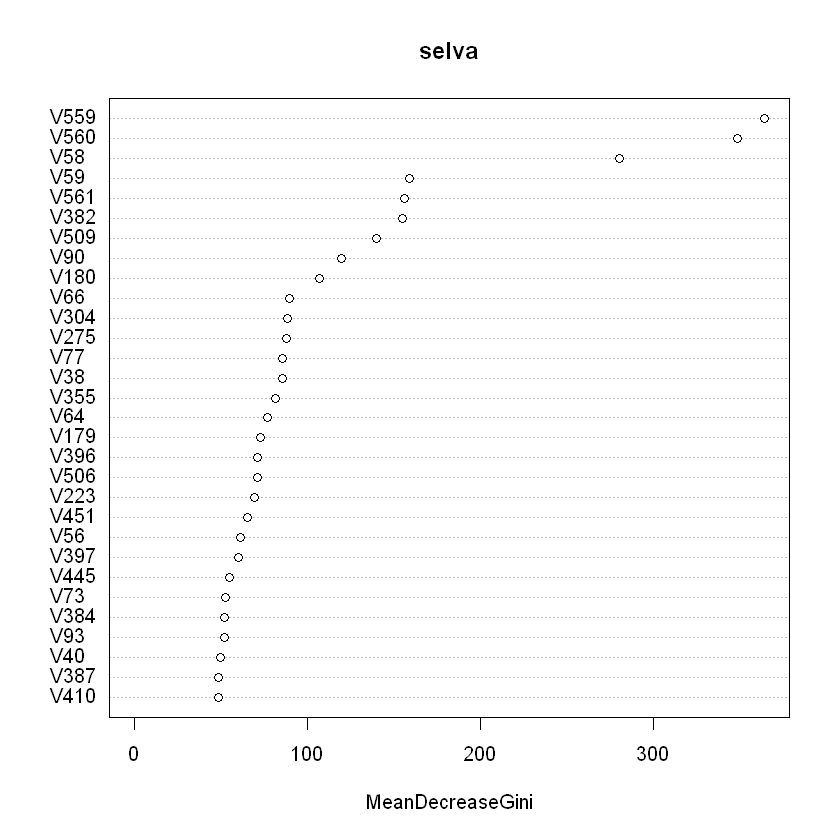

In [14]:
importancia<-importance(selva)
varImpPlot(selva)

In [15]:
features$V2[c(559,560,58)]

[1] angle-X-gravityMean  angle-Y-gravityMean  tGravityAcc-energy-Y
477 Levels: angle-tBodyAccJerkMean-gravityMean ... tGravityAccMag-std

Las tres variables más importantes son angle-X-gravityMean (559), angle-Y-gravityMean (560) y tGravityAcc-energy-Y (58). 

Ahora usaremos la función rfcv para seleccionar el número de covariables con las cuales quedarnos. Este paso demora bastante tiempo, en mi caso fueron 30 minutos. 

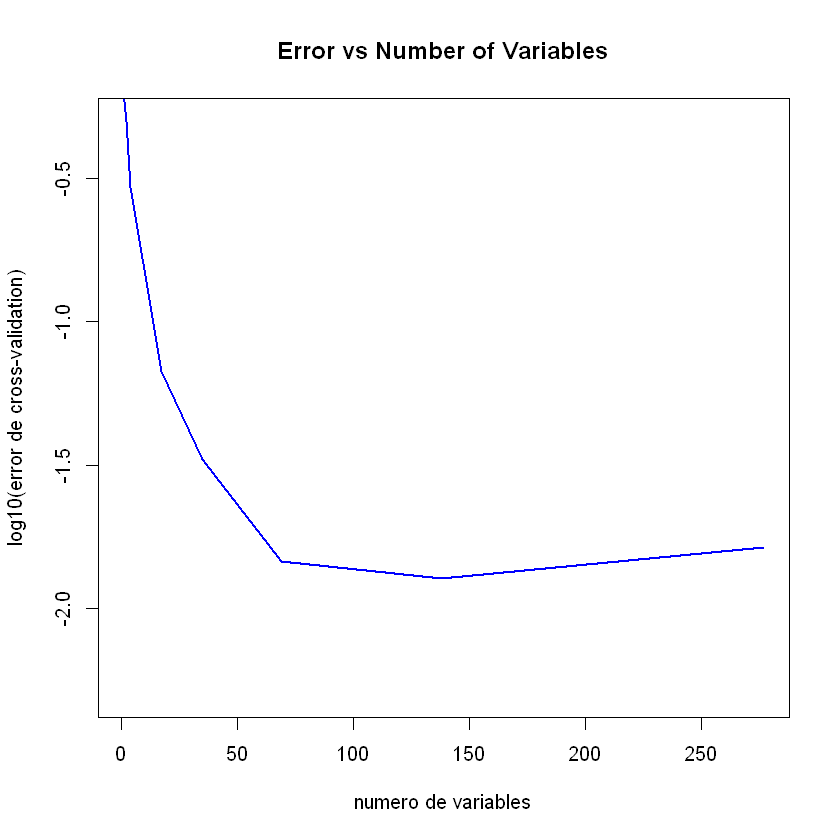

In [16]:
r<-rfcv(xfilter[,1:277],xfilter$activity,cv.fold=10,step=0.5)
plot(r$n.var,log10(r$error.cv),ylim=c(-2.3,-0.3),col='blue',type='l',lwd=2,xlab='numero de variables',ylab='log10(error de cross-validation)',main='Error vs Number of Variables')

El diagrama nos sugiere que a partir de aproximadamente 75 variables no hay reducciones sustanciales del error de cross-validation. Nos quedamos entonces con las 75 variables más importantes:

In [17]:
importancia_ordenada<-sort(importancia,index.return=TRUE, decreasing=TRUE)
index<-importancia_ordenada$ix[1:75]
xcrop=xfilter[,index]
xcrop=data.frame(xcrop,activity=xfilter$activity,subject=xfilter$subject)
names(xcrop)

[1] "V559"     "V560"     "V58"      "V59"      "V561"     "V382"    
 [7] "V509"     "V90"      "V180"     "V66"      "V304"     "V275"    
[13] "V77"      "V38"      "V355"     "V64"      "V179"     "V396"    
[19] "V506"     "V223"     "V451"     "V56"      "V397"     "V445"    
[25] "V73"      "V384"     "V93"      "V40"      "V387"     "V410"    
[31] "V285"     "V452"     "V63"      "V519"     "V221"     "V160"    
[37] "V296"     "V80"      "V449"     "V490"     "V461"     "V422"    
[43] "V78"      "V386"     "V370"     "V130"     "V177"     "V462"    
[49] "V137"     "V513"     "V133"     "V385"     "V94"      "V246"    
[55] "V298"     "V356"     "V433"     "V491"     "V92"      "V143"    
[61] "V299"     "V483"     "V372"     "V307"     "V39"      "V393"    
[67] "V333"     "V450"     "V317"     "V23"      "V400"     "V257"    
[73] "V411"     "V60"      "V186"     "activity" "subject"

Antes de continuar con nuestro análisis y viendo que tres variables son de lejos las más importantes, hacemos un par de gráficas de dichas variables combinadas en pares y coloreadas por actividad:

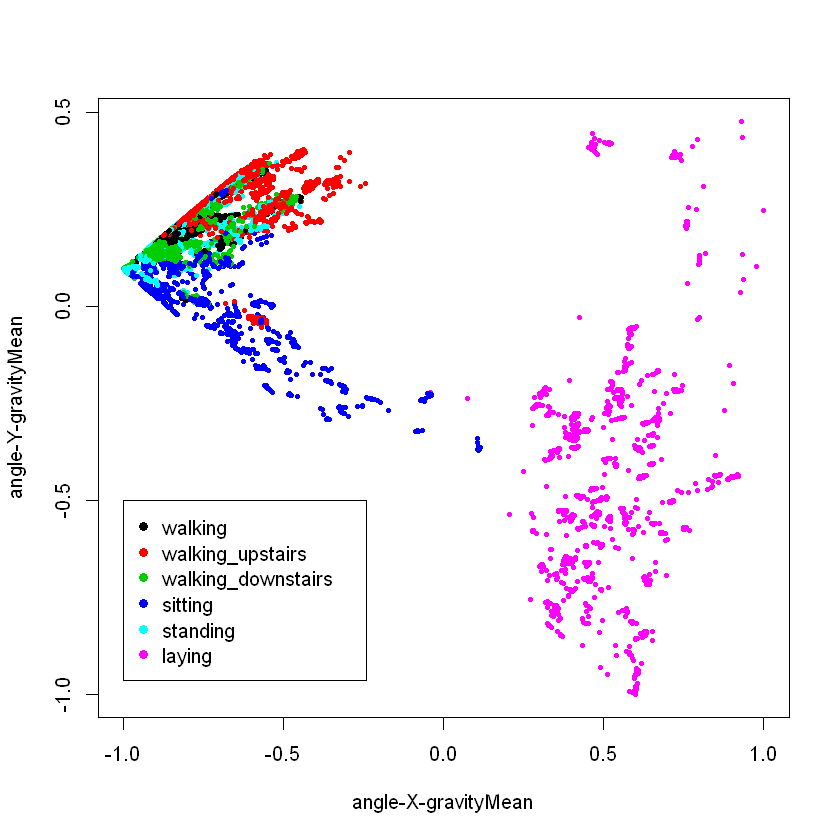

In [18]:
plot(xcrop[,1],xcrop[,2],col=xcrop$activity,pch=19,cex=0.5,xlab='angle-X-gravityMean',ylab='angle-Y-gravityMean')
legend(x=-1,y=-0.5,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)

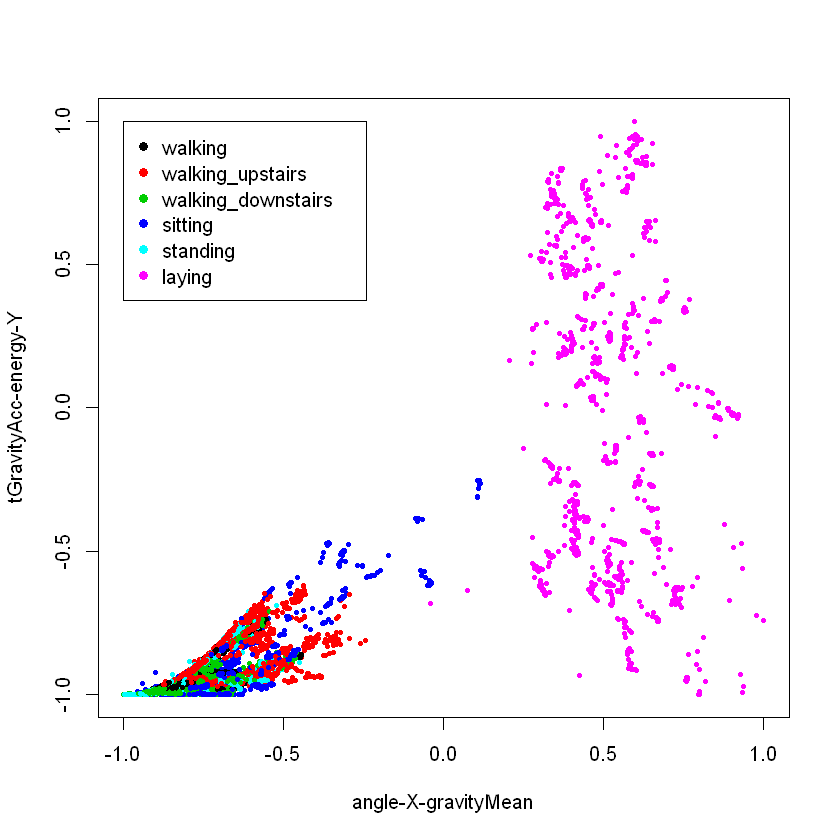

In [19]:
plot(xcrop[,1],xcrop[,3],col=xcrop$activity,pch=19,cex=0.5,xlab='angle-X-gravityMean',ylab='tGravityAcc-energy-Y')
legend(x=-1,y=1,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)

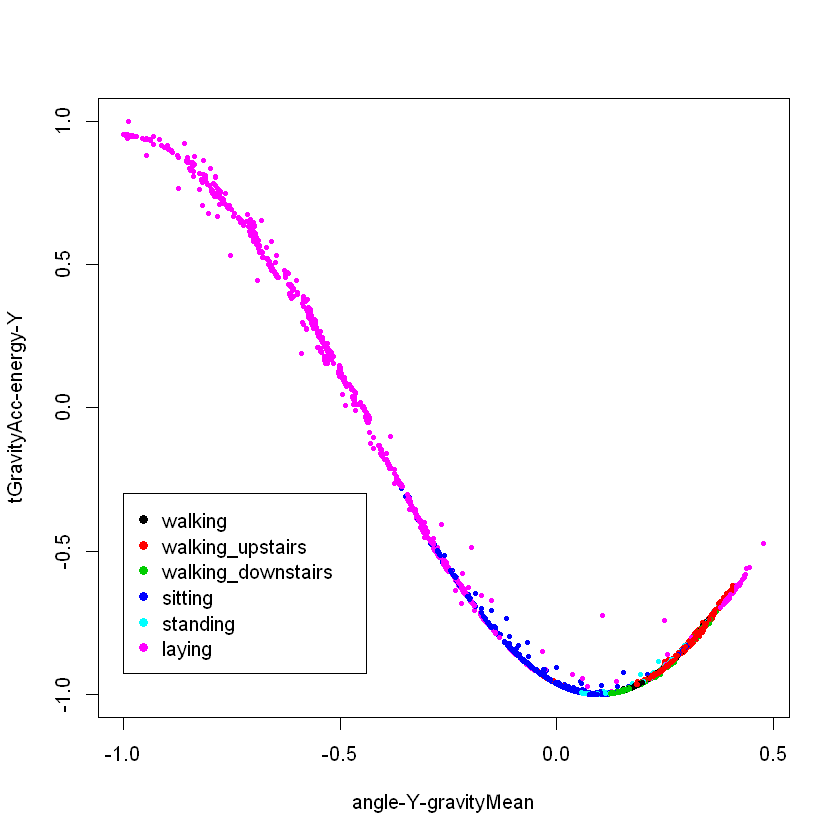

In [20]:
plot(xcrop[,2],xcrop[,3],col=xcrop$activity,pch=19,cex=0.5,xlab='angle-Y-gravityMean',ylab='tGravityAcc-energy-Y')
legend(x=-1,y=-0.3,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)

In [21]:
cor(xcrop[,c(2,3)])

,V560,V58
V560,1.0000000,-0.8805638
V58,-0.8805638,1.0000000


Vemos que la variable angle-X-gravityMean (559) separa LAYING de las demás actividades.

Las variables angle-Y-gravityMean (560) y tGravityAcc-energy-Y (58) están relacionadas por una función no lineal, en este caso senosoidal, lo cual explica porque dicha relación no fue detectada cuando eliminamos variables fuertemente correlacionadas. En este caso la correlación entre las dos variables es -0.88. Este último resultado nos sugiere una relación entre las variables llamadas angle-gravityMean y tGravityAcc-energy para los diferentes ejes. Como en nuestro caso dichas variables para el eje Z tambien están incluidas en nuestra selección de variables importantes, angle-Z-gravityMean (561) y tGravityAcc-energy-Z (59), decidimos también haceruna gráfica:

,V561,V59
V561,1.0000000,-0.6822727
V59,-0.6822727,1.0000000


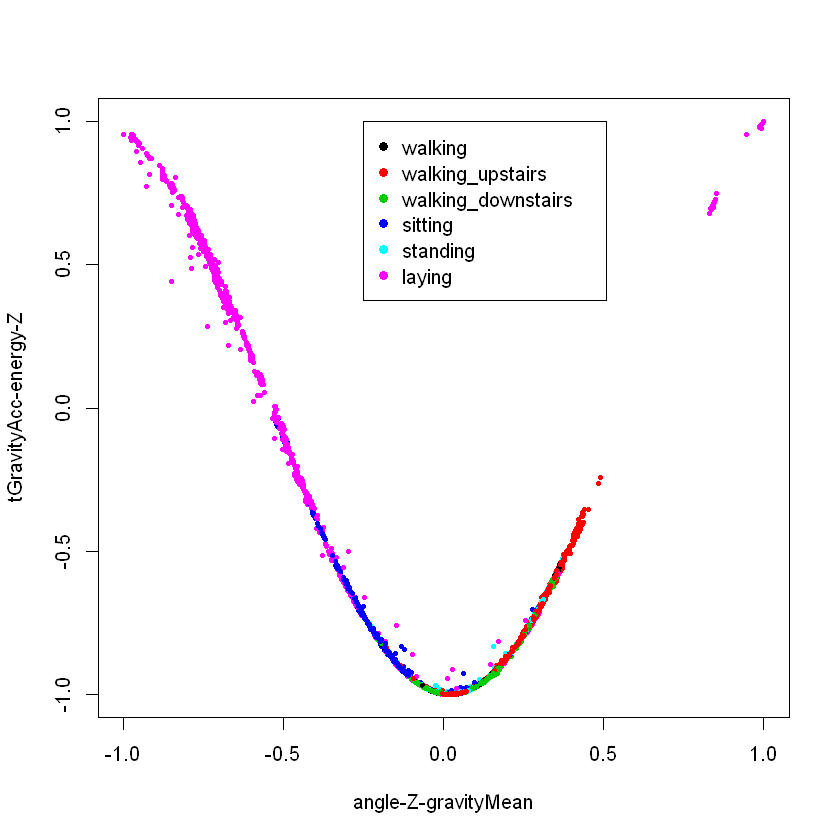

In [22]:
plot(xcrop[,5],xcrop[,4],col=xcrop$activity,pch=19,cex=0.5,xlab='angle-Z-gravityMean',ylab='tGravityAcc-energy-Z')
legend(x=-0.25,y=1.0,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)
cor(xcrop[,c(5,4)])

En este caso también hay una relación senosoidal entre las dos variables con una correlación de solo -0.68. 

Ambas gráficas poseen algunos puntos que se alejan del modelo senosoidal. Nos parece interesante en este caso saber si dichos outliers están de alguna manera relacionados. De la gráfica podemos inferir estan todos asociados con la actividad LAYING. Vamos ahora a tratar de detectarlos aproximando un modelo a las curvas y después ver que puntos se alejan más del modelo. En nuestro caso, el modelo senosoidal de ambas curvas fue ajustado manualmente:

Para la primera curva obtenemos:

    V58 = -0.975*cos(pi*(V560-0.1)/1.1)-0.025

y la segunda:

    V59 = -cos(pi*(V561-0.02)/1.1)
    
De forma gráfica:

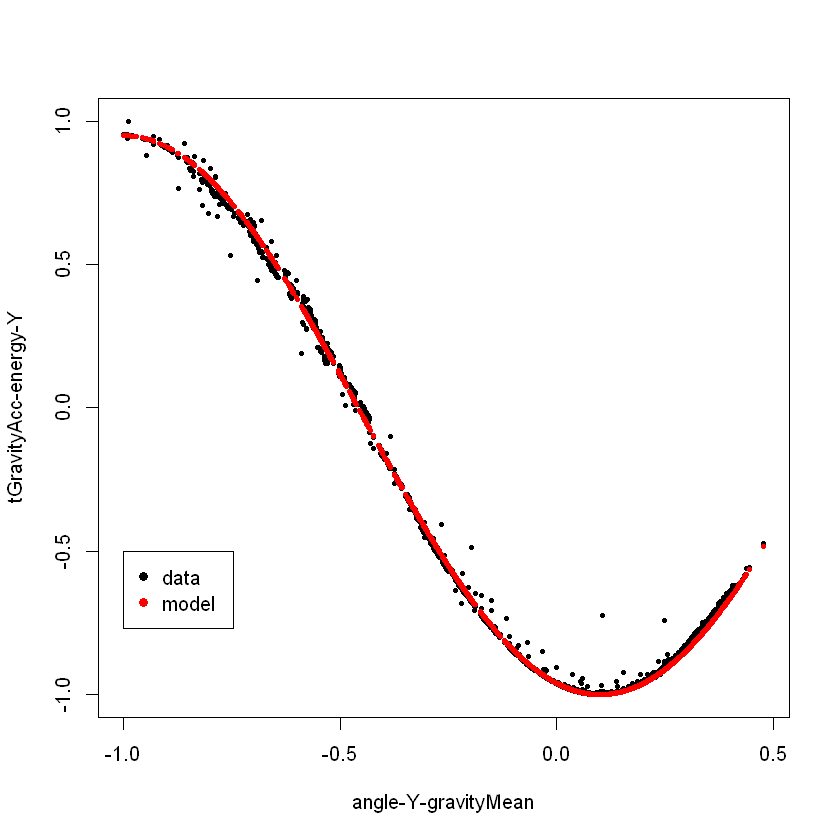

In [23]:
plot(xcrop[,2],xcrop[,3],pch=19,cex=0.5,xlab='angle-Y-gravityMean',ylab='tGravityAcc-energy-Y')
points(xcrop[,2],-0.975*cos(pi*(xcrop[,2]-0.1)/1.1)-0.025,col='red',pch=19,cex=0.5)
legend(x=-1,y=-0.5,col=c('black','red'),c('data','model'),pch=19)

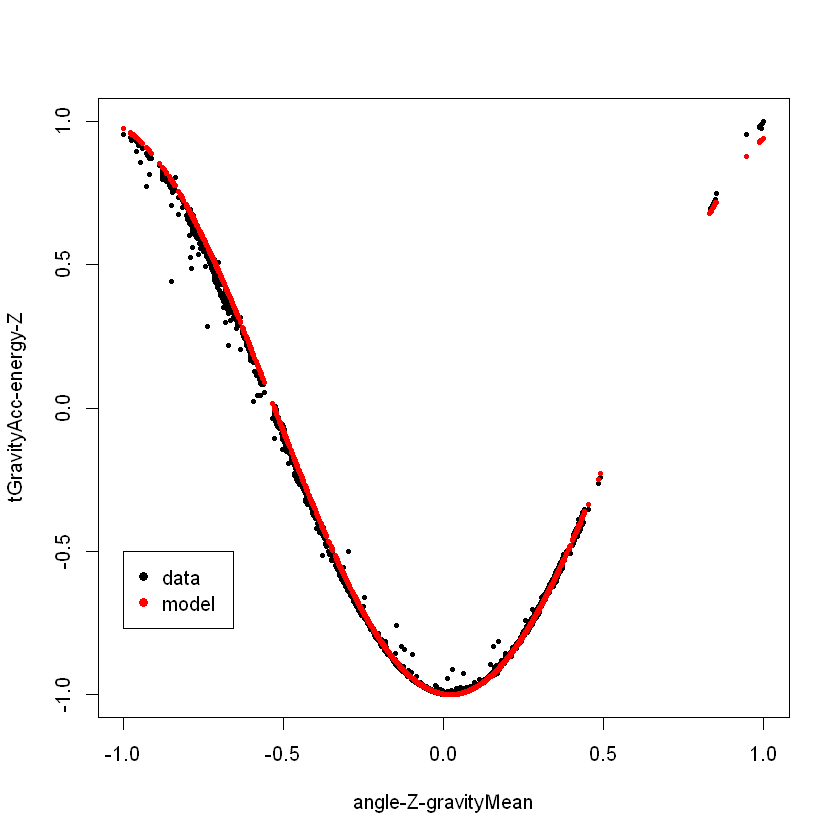

In [24]:
plot(xcrop[,5],xcrop[,4],pch=19,cex=0.5,xlab='angle-Z-gravityMean',ylab='tGravityAcc-energy-Z')
points(xcrop[,5],-cos(pi*(xcrop[,5]-0.02)/1.1),col='red',pch=19,cex=0.5)
legend(x=-1,y=-0.5,col=c('black','red'),c('data','model'),pch=19)

En este punto nosparece interesante explorar si dichas diferencias entre el valor medido y los modelos tienen alguna relación con el usuario o smartphone utilizado. Para eso hacemos una gráfica de boxplot en función del sujeto:

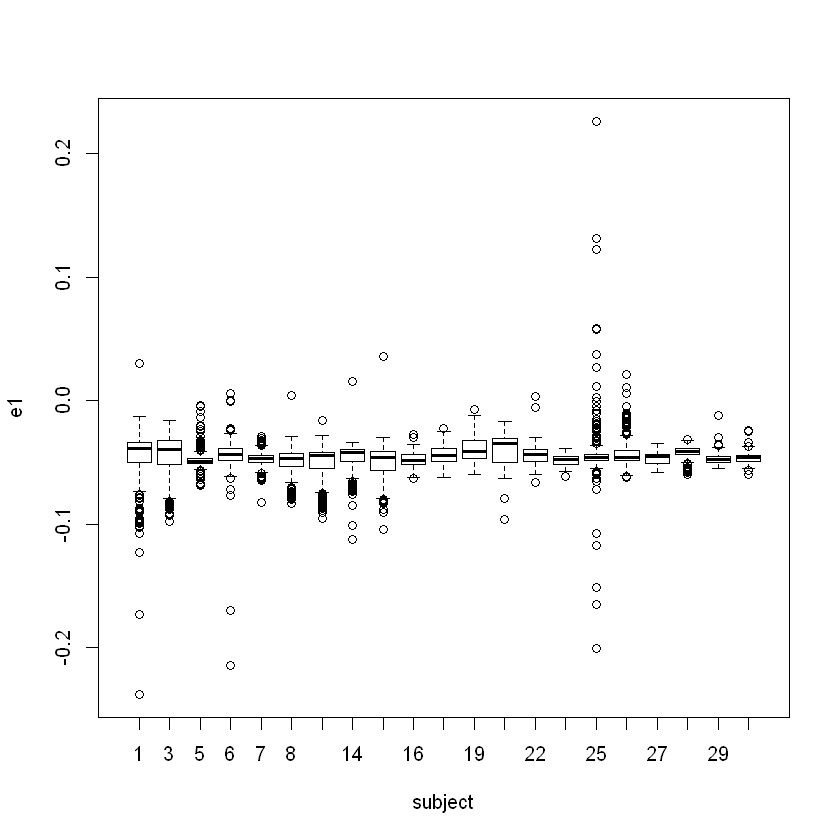

In [25]:
e1 <- xcrop[,3] + 0.975*cos(pi*(xcrop[,2]-0.1)/1.1)-0.025
plot(e1~xcrop$subject,xlab='subject')

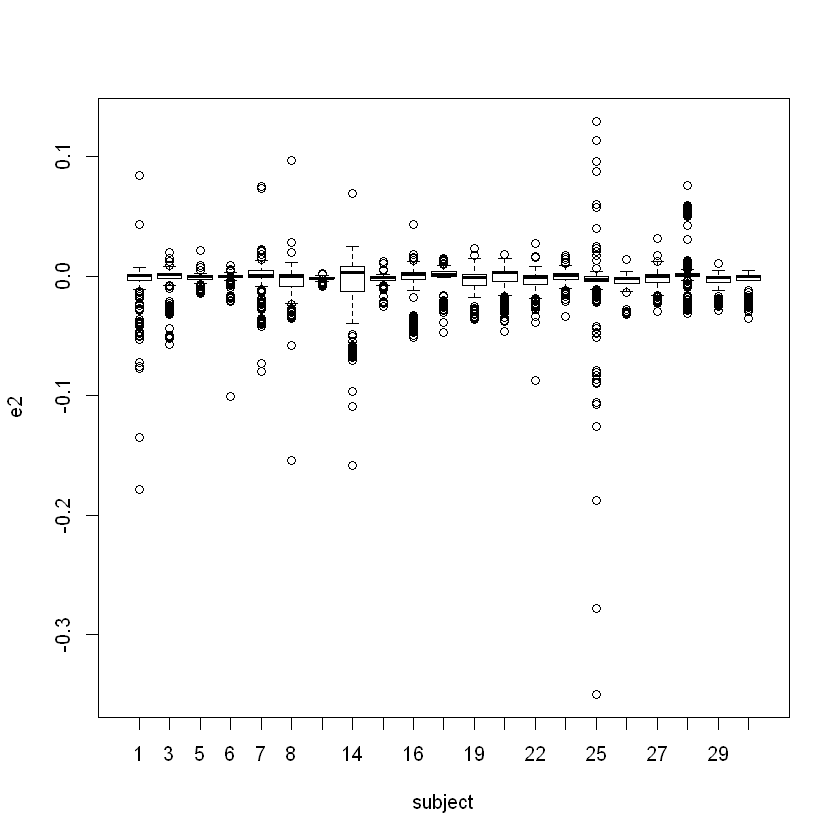

In [26]:
e2 <- xcrop[,4] + cos(pi*(xcrop[,5]-0.02)/1.1)
plot(e2~xcrop$subject,xlab='subject')

Ambas gráficas nos muestran que el sujeto número 25 concentra muchas de las mayores desviaciones entre valor medido y modelo. Aunque no sabemos las causas de dichas divergencias,el hecho que se concentren en un solo sujeto nossugiere que algo atípico ocurre con el sujeto o su smartphone. Una de las posibles causas que se nos ocurren pero no podemos coprobar es que quizás el smartphone del respectivo usuario tiene algún tipo de defecto. Basados en esta suposición y como tenemos disponibles datos para muchos más usuarios hemos decidido eliminar las observaciones del usuario 25:

In [27]:
xcrop=subset(xcrop,subject!=25)

# Partición de los datos en train y  test

Procedemos ahora a dividir los datos en dos conjuntos: uno para el entrenamiento del modelo (train) y otro para la evaluación del desempeño (test). Para el entrenamiento usaremos 70% de las observaciones y para el test el 30% restante:

In [28]:
library(caTools)
index_train=sample.split(xcrop$activity,SplitRatio=0.7)
x_train=subset(xcrop,index_train==TRUE)
x_test=subset(xcrop,index_train==FALSE)

Verificamos ahora que las distribuciones de actividades en los dos conjuntos sean similares: 

In [29]:
table(x_train$activity)/nrow(x_train)
table(x_test$activity)/nrow(x_test)


           WALKING   WALKING_UPSTAIRS WALKING_DOWNSTAIRS            SITTING 
         0.1658095          0.1452376          0.1337173          0.1758897 
          STANDING             LAYING 
         0.1872043          0.1921415 


           WALKING   WALKING_UPSTAIRS WALKING_DOWNSTAIRS            SITTING 
         0.1661864          0.1450528          0.1335255          0.1757925 
          STANDING             LAYING 
         0.1873199          0.1921230 

Las distribuciones son muy similares.

# Normalización de las variables

Una exploración rápida del valor medio y la desviación estandar de las 75 variables más importantes nos muestra que las variables poseen diferentes rangos:

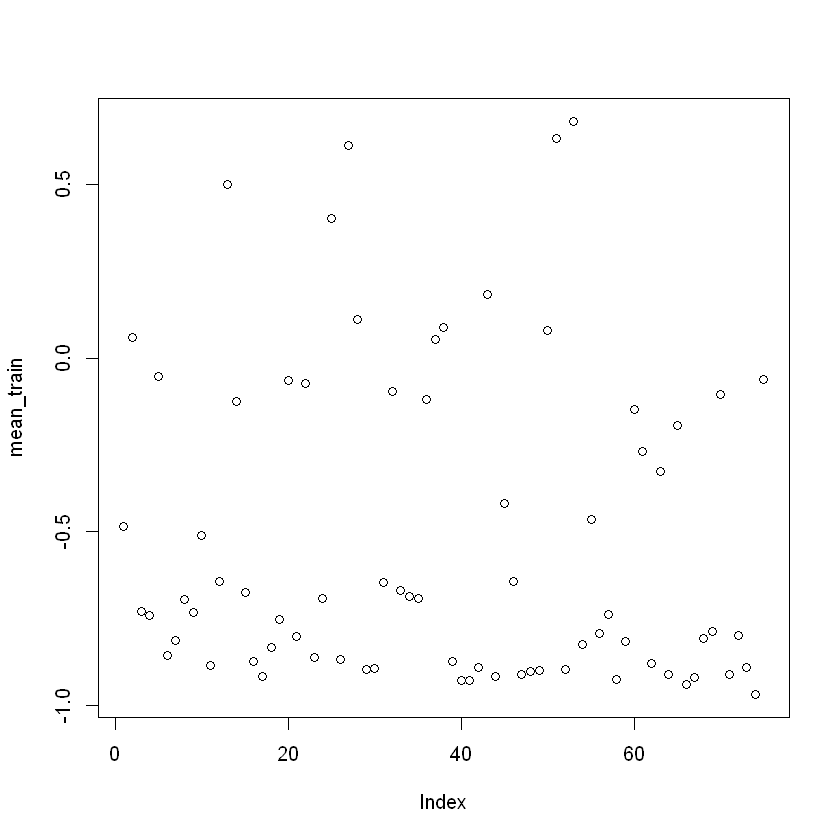

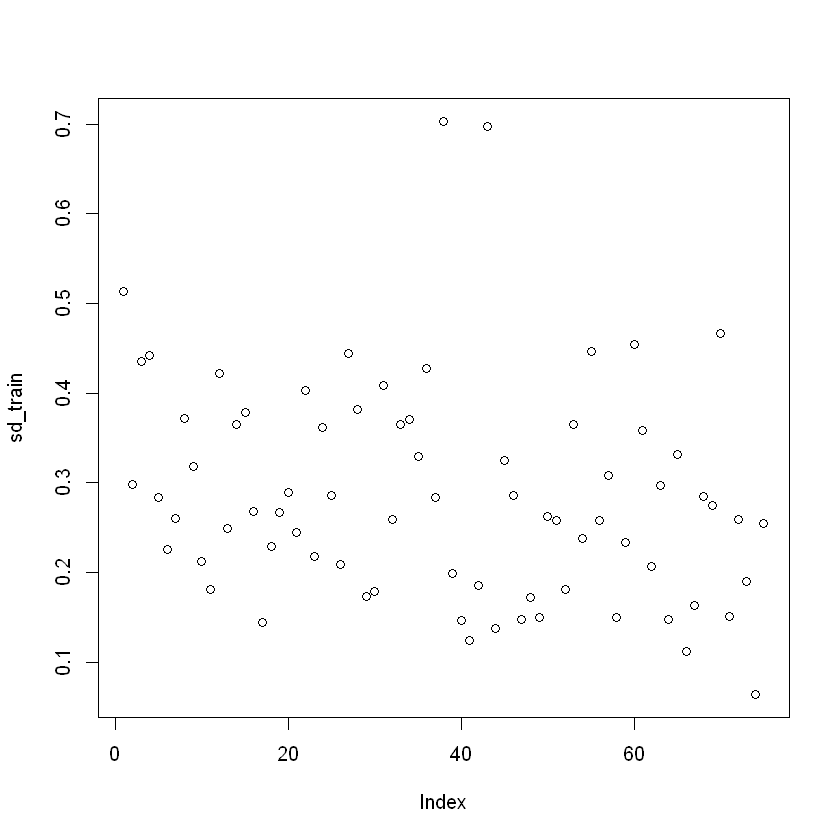

In [30]:
mean_train <- apply(x_train[,1:75],2,mean)
sd_train <- apply(x_train[,1:75],2,sd)
plot(mean_train)
plot(sd_train)

procedemos entonces a normalizar las variables. Ya que no debemos usar los datos del test set para generar transformaciones de los datos, este set se normaliza con la media y la desviación estandard halladas para el training set:

In [31]:
xnorm_train <- scale(x_train[,1:75])
xnorm_test <- scale(x_test[,1:75],center=mean_train,scale=sd_train)

# Componentes principales usando SVD

Calcularemos los componentes principales usando svd sobre el training set. Una vez hallados los vectores de loadings correspondientes, los datos del test set se proyectarán usando estos vectores:

In [32]:
svd_train <- svd(xnorm_train)
svd_test <- xnorm_test%*%solve(t(svd_train$v))%*%diag(1/svd_train$d)

hagamos ahora una gráfica de la varianza explicada por los componentes:

[1] 0.45784725 0.08341817 0.06109992 0.02986949 0.02886352 0.02396556

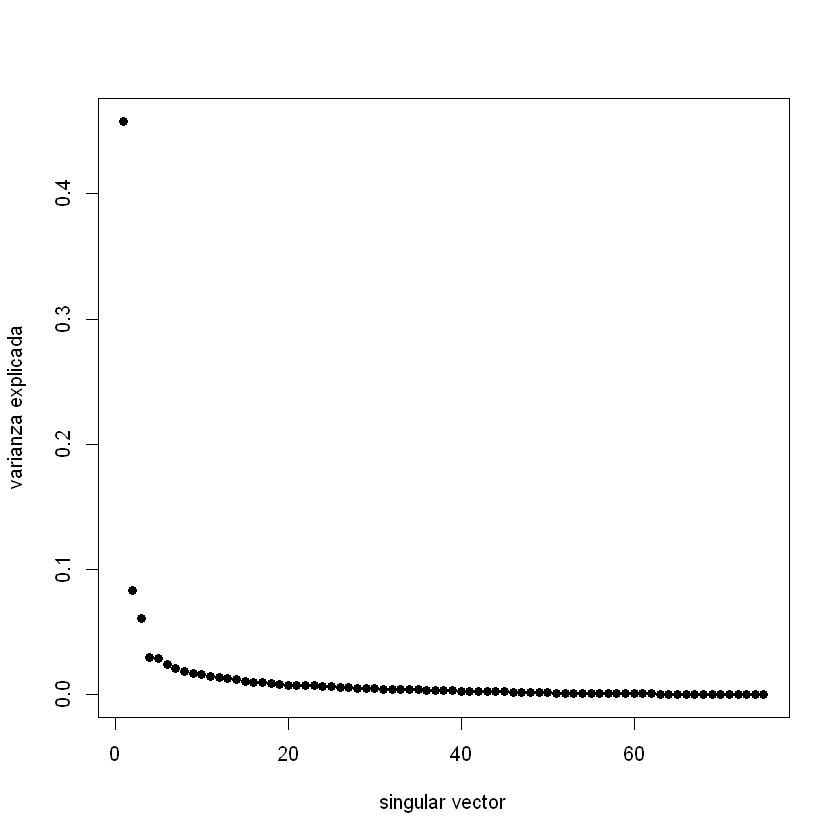

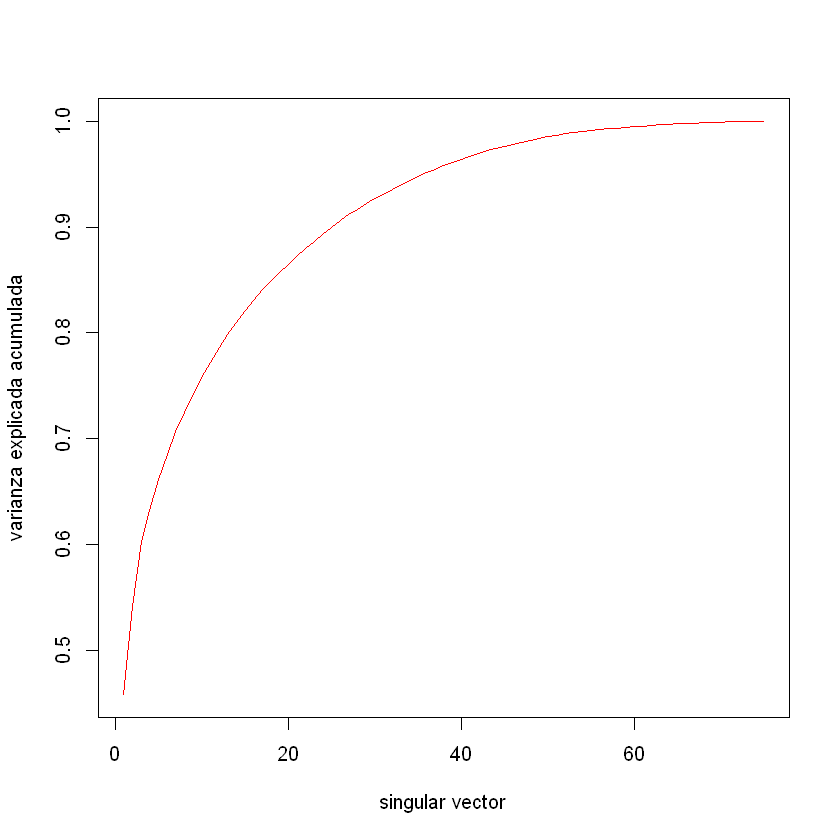

In [33]:
var_explained <- svd_train$d^2/sum(svd_train$d^2)
head(var_explained)
plot(var_explained,xlab="singular vector",ylab="varianza explicada",pch=19)
plot(cumsum(var_explained),type="l",col="red",xlab="singular vector",ylab="varianza explicada acumulada")

El primer componente representa el 46% de la varianza, el segundo un 8% y el tercero un 6%.
Los primeros veinte componentes acumulan un 86% de la varianza y los primeros 50 un 96%.

Echemos ahora un vistazo a la proyección de las actividades usando los primeros componentes:

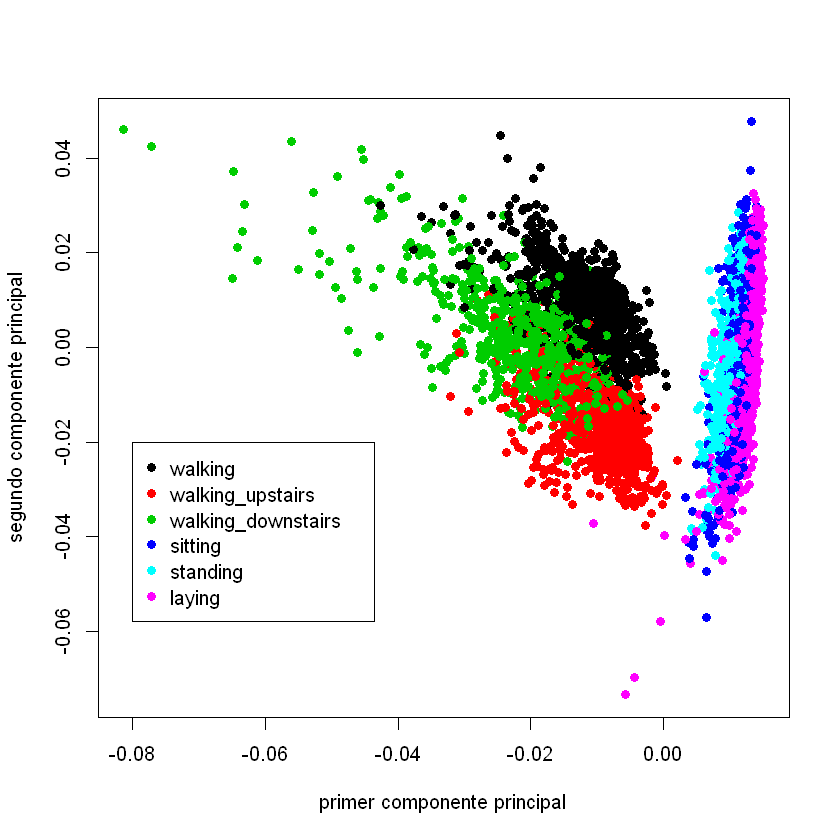

In [34]:
plot(svd_train$u[,1],svd_train$u[,2],col=x_train$activity,pch=19,xlab='primer componente principal',ylab='segundo componente principal')
legend(x=-0.08,y=-0.02,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)


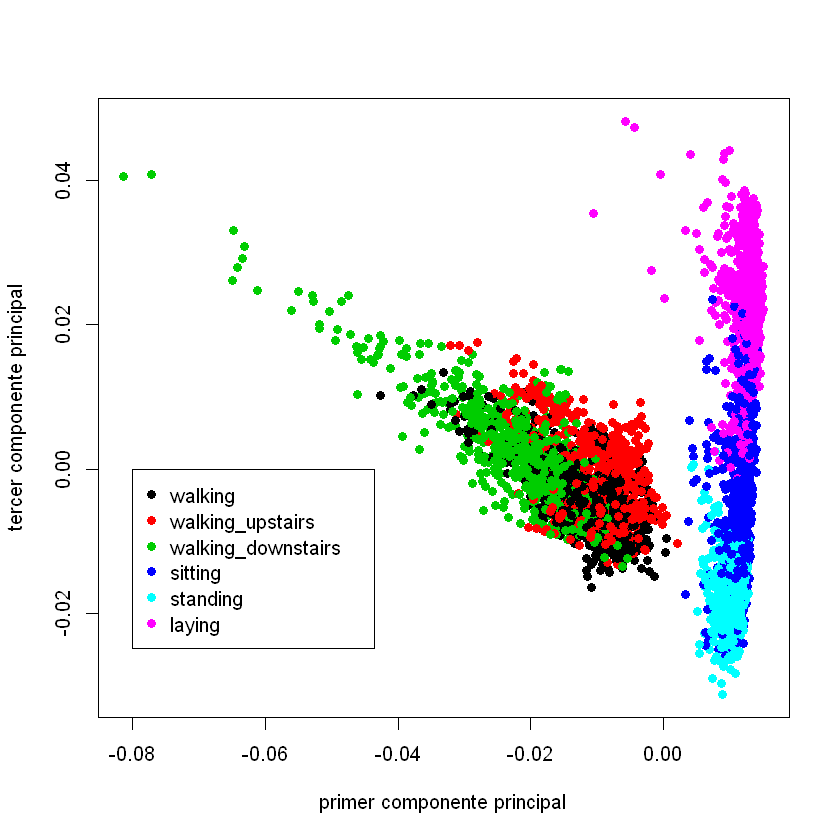

In [36]:
plot(svd_train$u[,1],svd_train$u[,3],col=x_train$activity,pch=19,xlab='primer componente principal',ylab='tercer componente principal')
legend(x=-0.08,y=0.0,col=1:6,c("walking","walking_upstairs","walking_downstairs","sitting","standing","laying"),pch=19)


El primer componente separa las actividades reposadas (SITTING, STANDING, LAYING) de las actividades con mas movimiento (WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS). 

El primer componente combinado con el segundo permite cierta separación de las activades de caminar entre si. El primer componente combinado con el tercero hacen visible una separación de las actividades reposadas entre si. En ambos casos la separación no es perfecta sino que hay un overlaping considerable.

Para seleccionar el numero de componentes a preservar utilizamos de nuevo la cross-validation implementada en la función rfcv del la librería randomForest:

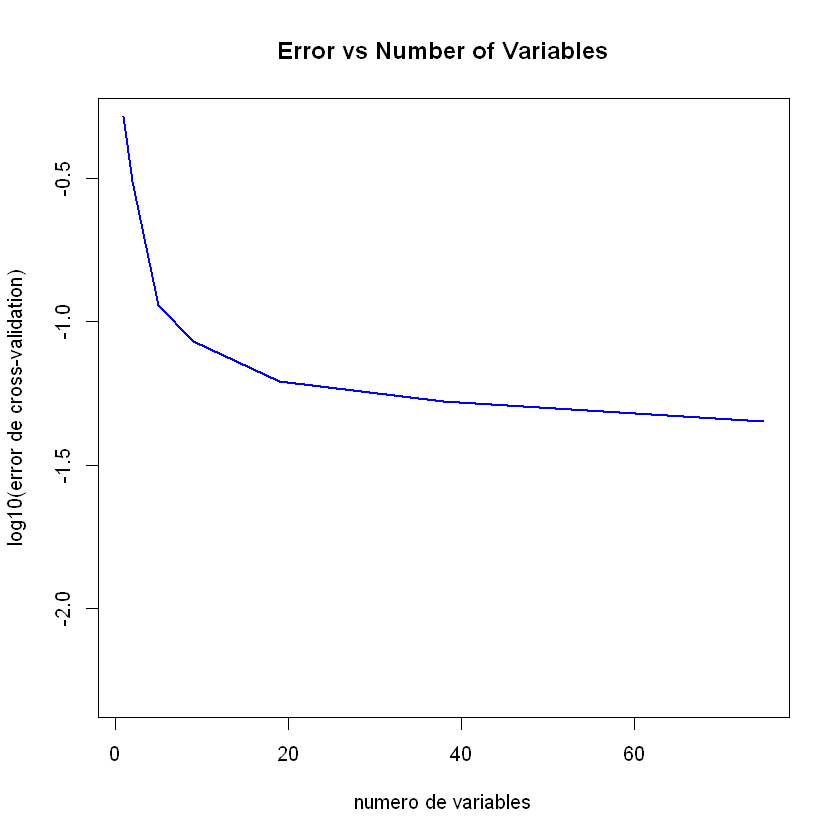

In [37]:
r_svd<-rfcv(svd_train$u,x_train$activity,cv.fold=10,step=0.5)
plot(r_svd$n.var,log10(r_svd$error.cv),ylim=c(-2.3,-0.3),col='blue',type='l',lwd=2,xlab='numero de variables',ylab='log10(error de cross-validation)',main='Error vs Nummero de Variables')


Los resultados sugieren conservar 20 componentes principales. A partir de este número no hay decrementos significativos del error de cross-validation:

In [38]:
data_svd_train=data.frame(svd_train$u[,1:20],activity=x_train$activity)
data_svd_test=data.frame(svd_test[,1:20],activity=x_test$activity)

# Modelos de árbol

Primero creemos un árbol con las 75 variables más importantes de los datos sin transformar:  

In [40]:
library (C50)
data_train=data.frame(x_train[,1:75],activity=x_train$activity)
data_test=data.frame(x_test[,1:75],activity=x_test$activity)
arbol <- C50::C5.0(activity~.,data_train)
summary(arbol)


Call:
C5.0.formula(formula = activity ~ ., data = data_train)


C5.0 [Release 2.07 GPL Edition]  	Sat Dec 03 12:34:54 2016
-------------------------------

Class specified by attribute `outcome'

Read 4861 cases (76 attributes) from undefined.data

Decision tree:

V382 > -0.9801019:
:...V509 > -0.5469348:
:   :...V160 > 0.2540088:
:   :   :...V451 <= -0.7931035: WALKING_UPSTAIRS (54)
:   :   :   V451 > -0.7931035: WALKING_DOWNSTAIRS (4)
:   :   V160 <= 0.2540088:
:   :   :...V66 > -0.2707941:
:   :       :...V561 <= 0.1891547: WALKING (9)
:   :       :   V561 > 0.1891547: WALKING_DOWNSTAIRS (4)
:   :       V66 <= -0.2707941:
:   :       :...V519 <= -0.5155157:
:   :           :...V451 <= -0.7931035: WALKING_UPSTAIRS (12)
:   :           :   V451 > -0.7931035:
:   :           :   :...V559 <= -0.7167579: WALKING_DOWNSTAIRS (5)
:   :           :       V559 > -0.7167579: WALKING_UPSTAIRS (2/1)
:   :           V519 > -0.5155157:
:   :           :...V58 > -0.8508096:
:   :               :..

El árbol resultante es bastante complejo, contiene 87 hojas y genera una tasa de error de 0.8% en el training set. Son 37 errores en total. La mayor confusión se presenta entre las clases STANDING y SITTING. Las primeras 21 variables se utilizan con una frecuencia superior al 10%.

Una gráfica de todo el árbol sera muy dificil de leer:

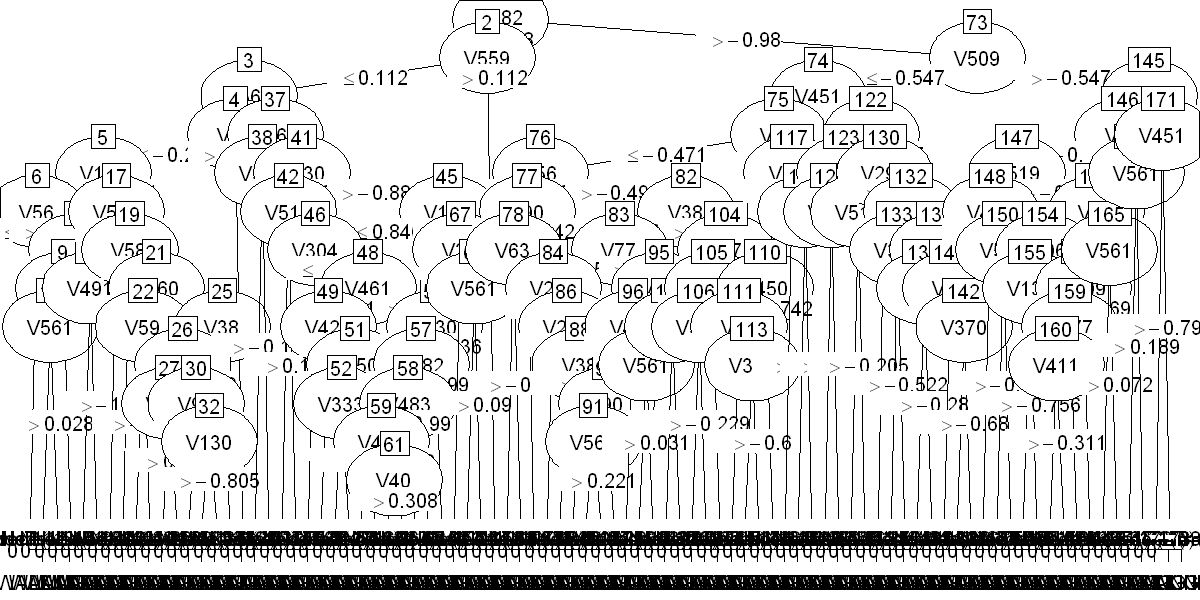

In [41]:
options(repr.plot.width=10, repr.plot.height=5)
plot(arbol)

Podemos tambien solo mostrar un subarbol, por ejemplo: 

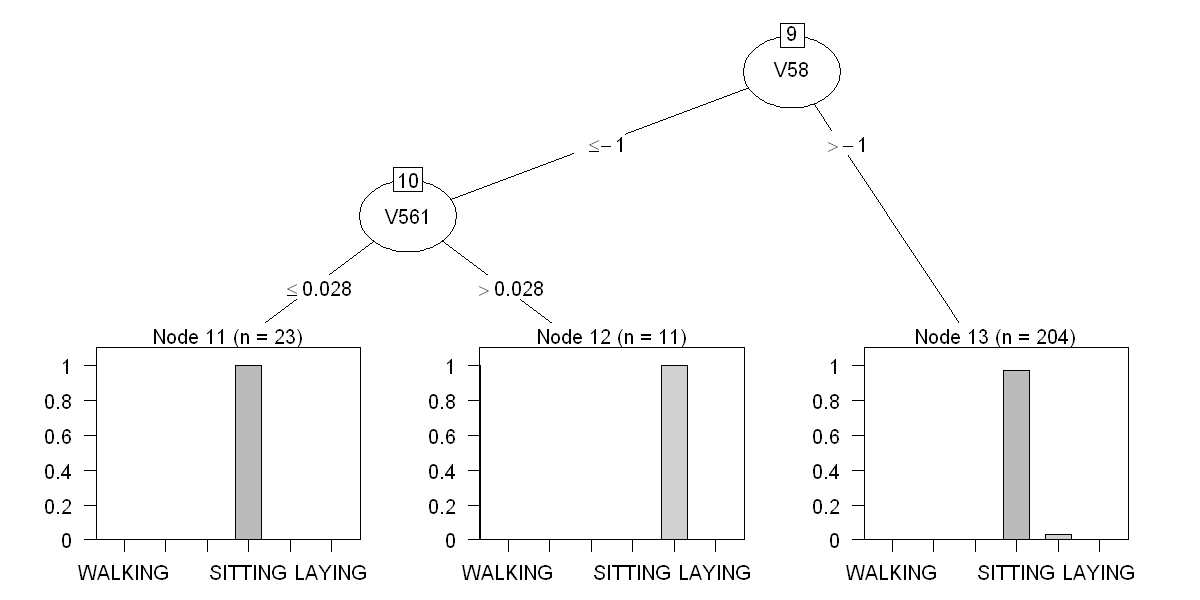

In [45]:
plot(arbol,subtree=9)

Los nodos 11, 12 y 13 son hojas. El nodo 11 clasifica todo sus 23 casos como SITTING (clase número 4) sin errores, el nodo 12 clasifica todo sus 11 casos como STANDING (clase número 5) sin errores, y el nodo 13 clasifica sus 204 casos como SITTING aunque con algunos errores pertenecientes a la clase STANDING.   

Evaluemos ahora el modelo con el test set:

In [46]:
y_predict<- predict(arbol,data_test,type ="class")
table(x_test$activity,y_predict)
sum(x_test$activity==y_predict)/nrow(x_test)

                    y_predict
                     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING
  WALKING                333                8                  5       0
  WALKING_UPSTAIRS        10              281                 11       0
  WALKING_DOWNSTAIRS      10                9                258       0
  SITTING                  0                0                  0     336
  STANDING                 0                0                  0      30
  LAYING                   0                0                  0       0
                    y_predict
                     STANDING LAYING
  WALKING                   0      0
  WALKING_UPSTAIRS          0      0
  WALKING_DOWNSTAIRS        0      1
  SITTING                  29      1
  STANDING                360      0
  LAYING                    0    400

[1] 0.945245

La exactitud del modelo con 94.5% es alta. La mayor cantidad de errores se siguen presentando entre las clases SITTING y STANDING. 

Creemos ahora un modelo con solo los primeros 20 componentes principales:

In [47]:
arbol_svd <- C50::C5.0(activity~.,data_svd_train)
summary(arbol_svd)


Call:
C5.0.formula(formula = activity ~ ., data = data_svd_train)


C5.0 [Release 2.07 GPL Edition]  	Sat Dec 03 13:21:53 2016
-------------------------------

Class specified by attribute `outcome'

Read 4861 cases (21 attributes) from undefined.data

Decision tree:

X1 <= 0.002041156:
:...X2 <= -0.008783054:
:   :...X3 > 0.01336592:
:   :   :...X2 <= -0.02049534: LAYING (6)
:   :   :   X2 > -0.02049534:
:   :   :   :...X9 <= 0.003046673: WALKING_UPSTAIRS (3)
:   :   :       X9 > 0.003046673: WALKING_DOWNSTAIRS (3)
:   :   X3 <= 0.01336592:
:   :   :...X10 > 0.006176517:
:   :       :...X2 <= -0.01668049:
:   :       :   :...X5 <= 0.01171432: WALKING_UPSTAIRS (51/1)
:   :       :   :   X5 > 0.01171432:
:   :       :   :   :...X1 <= -0.01059143: WALKING_DOWNSTAIRS (5)
:   :       :   :       X1 > -0.01059143: WALKING_UPSTAIRS (3)
:   :       :   X2 > -0.01668049:
:   :       :   :...X11 <= -0.002994375:
:   :       :       :...X2 <= -0.01047177: WALKING_UPSTAIRS (11)
:   :       :    

El árbol resultante tiene muchas mas hojas que el árbol anterior y genera muchos mas errores en el training set, en total 116 para una tasa de error del 2.4%. La totalidad de las 20 variables es utilizada en el arbol, 15 de ellas con mas del 10%.

Evaluado sobre el test set:

In [48]:
y_svd_predict<- predict(arbol_svd,data_svd_test,type ="class")
table(x_test$activity,y_svd_predict)
sum(x_test$activity==y_svd_predict)/nrow(x_test)

                    y_svd_predict
                     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING
  WALKING                323               10                 13       0
  WALKING_UPSTAIRS        15              274                 13       0
  WALKING_DOWNSTAIRS      16               15                247       0
  SITTING                  0                1                  0     287
  STANDING                 0                0                  0      72
  LAYING                   0                0                  0      10
                    y_svd_predict
                     STANDING LAYING
  WALKING                   0      0
  WALKING_UPSTAIRS          0      0
  WALKING_DOWNSTAIRS        0      0
  SITTING                  69      9
  STANDING                318      0
  LAYING                    0    390

[1] 0.8832853

La exactitud en este caso, 88%, es también mucho menor que la del arbol con las variables originales. Aunque el número de confusiones entre las clases WALKING aumenta, la mayor parte de las confusiones sigue siendo entre STANDING y SITTING.

Creemos ahora un árbol con las variables originales mas importantes mas los cinco primeros componentes principales:

In [50]:
data_train=data.frame(x_train[,1:75],svd_train$u[,1:5],activity=x_train$activity)
data_test=data.frame(x_test[,1:75],svd_test[,1:5],activity=x_test$activity)
arbol_hibrido <- C50::C5.0(activity~.,data_train)
y_predict<- predict(arbol_hibrido,data_test,type ="class")
table(x_test$activity,y_predict)
sum(x_test$activity==y_predict)/nrow(x_test)

                    y_predict
                     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING
  WALKING                328               10                  8       0
  WALKING_UPSTAIRS        10              285                  7       0
  WALKING_DOWNSTAIRS       5               11                260       0
  SITTING                  0                0                  0     336
  STANDING                 0                0                  0      30
  LAYING                   0                0                  0       0
                    y_predict
                     STANDING LAYING
  WALKING                   0      0
  WALKING_UPSTAIRS          0      0
  WALKING_DOWNSTAIRS        0      2
  SITTING                  29      1
  STANDING                360      0
  LAYING                    0    400

[1] 0.9457253

In [51]:
summary(arbol_hibrido)


Call:
C5.0.formula(formula = activity ~ ., data = data_train)


C5.0 [Release 2.07 GPL Edition]  	Sat Dec 03 13:38:49 2016
-------------------------------

Class specified by attribute `outcome'

Read 4861 cases (81 attributes) from undefined.data

Decision tree:

V382 > -0.9801019:
:...V509 > -0.5469348:
:   :...V160 > 0.2540088:
:   :   :...V451 <= -0.7931035: WALKING_UPSTAIRS (54)
:   :   :   V451 > -0.7931035: WALKING_DOWNSTAIRS (4)
:   :   V160 <= 0.2540088:
:   :   :...V66 > -0.2707941:
:   :       :...V561 <= 0.1891547: WALKING (9)
:   :       :   V561 > 0.1891547: WALKING_DOWNSTAIRS (4)
:   :       V66 <= -0.2707941:
:   :       :...V519 <= -0.5155157:
:   :           :...X2 > -0.001995261: WALKING_DOWNSTAIRS (4)
:   :           :   X2 <= -0.001995261:
:   :           :   :...V38 <= -0.6174412: WALKING_DOWNSTAIRS (2/1)
:   :           :       V38 > -0.6174412: WALKING_UPSTAIRS (13)
:   :           V519 > -0.5155157:
:   :           :...V58 > -0.8508096:
:   :               :..

La mejora del desempeño del modelo comparado con el árbol de las variables originales no es mucha tanto el el training como el test set. De los componentes principales agregados, solo el segundo componente (X2) es realmente utilizado, los demas componentes principales son irrelevantes.

La inclusión de componentes principales no parece traer ventajas significativas en la creación de un clasificador para los datos que nos ocupan. Los componentes combinan quizás variables que es mejor tener separadas para propósitos de clasificación. el hecho de que el árbol hibrido incluya el segundo y no el primer componente en sus decisiones nos indica que quizas el objetivo de los componentes que es concentrar la varianza en pocas variables no es necesariamente compatible con los objetivos de la clasificación. 

Antes de cerrar este trabajo, queremos considerar el randomForest con 100 árboles como modelo usando los datos originales como variables de entrada:

In [52]:
data_train=data.frame(x_train[,1:75])
data_test=data.frame(x_test[,1:75])
rarbol <- randomForest(data_train,x_train$activity,ntree=100,prox=TRUE)
y_predict<- predict(rarbol,data_train,type ="class")
table(x_train$activity,y_predict)
sum(x_train$activity==y_predict)/nrow(x_train)

                    y_predict
                     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING
  WALKING                806                0                  0       0
  WALKING_UPSTAIRS         0              706                  0       0
  WALKING_DOWNSTAIRS       0                0                650       0
  SITTING                  0                0                  0     855
  STANDING                 0                0                  0       0
  LAYING                   0                0                  0       0
                    y_predict
                     STANDING LAYING
  WALKING                   0      0
  WALKING_UPSTAIRS          0      0
  WALKING_DOWNSTAIRS        0      0
  SITTING                   0      0
  STANDING                910      0
  LAYING                    0    934

[1] 1

In [54]:
y_predict<- predict(rarbol,data_test,type ="class")
table(x_test$activity,y_predict)
sum(x_test$activity==y_predict)/nrow(x_test)
sum(x_test$activity!=y_predict)

                    y_predict
                     WALKING WALKING_UPSTAIRS WALKING_DOWNSTAIRS SITTING
  WALKING                344                2                  0       0
  WALKING_UPSTAIRS         0              299                  3       0
  WALKING_DOWNSTAIRS       1                1                276       0
  SITTING                  0                1                  0     343
  STANDING                 0                0                  0      22
  LAYING                   0                1                  0       0
                    y_predict
                     STANDING LAYING
  WALKING                   0      0
  WALKING_UPSTAIRS          0      0
  WALKING_DOWNSTAIRS        0      0
  SITTING                  22      0
  STANDING                368      0
  LAYING                    0    399

[1] 0.9745437

[1] 53

Con 53 errores y una exactitud del 97.5% en el test set este modelo logra una mejora significativa del desempeño. La mayoría de las confusiones, 44 en total, sigue siendo entre las clases STANDING y SITTING. 

Haciendo una tabla de los errores versus sujeto en el test set vemos que los usuarios 28, 16 y 5 presentan la mayor cantidad de errores. Este es quizas un aspecto en el que podriamos profundizar. Tienen dichos usuarios o sus telefonnos algun tipo de caracterísca que los diferencie de los demas: 

In [58]:
table((x_test$activity!=y_predict),x_test$subject)

       
          1   3   5   6   7   8  11  14  15  16  17  19  21  22  23  25  26  27
  FALSE 115 100  64  90  85  63  97  86 112 117 126  89 140  92 106   0 111 106
  TRUE    2   2   7   4   2   3   0   4   0   8   3   0   1   0   1   0   1   0
       
         28  29  30
  FALSE 101 106 123
  TRUE   11   0   4

# Conclusiones

La clasificación de las actividades de un usuario basado en los datos generados por los sensores de su smartphone se puede realizar con bastante exactitud usando árboles de decisión. Si se agregan los resultados de muchos árboles aleatorios, como sucede en el caso del random forest, los resultados son aun mejores.

La reducción del número de características primero por cantidad de correlación y después por importancia nos permitio obtener un modelo de buen desempeño sin tener que usar la totalidad de las variables disponibles. En nuestro caso de las 561 variables originales, solo 75 fueron utilizadas. La correlación nos permitió reducir mas de la mitad de las características aunque algunas variables relacionadas entre si por algun modelo no lineal no fueron eliminadas. La correlación no está diseñada para detectar este tipo de relaciones.

Aunque la detección de outliers no fue el foco de este trabajo, el que hayamos descubierto un par de variables relacionadas por medio de un modelo no lineal que pudimos aproximar con relativa precisión nos permitió detectar observaciones alejadas del modelo. El hecho de que las variaciones mas grandes estuvieran asociadas con un solo usuario nos hizo suponer que algo con el o su smartphone no estaba bien. No tenemos mas datos para confirmar esta afirmación.

Los componentes principales, aunque muy útiles para comprimir los datos, no son siempre la herramiente idonea para crear un modelo de clasificación con árboles. Los componentes principales son de por si una combinación de las covariables y quizá esta combinación no sea siempre lo mas apropiado. Algunas de las covariables de manera aislada aportan mas a la toma de decisiones que si se las combina con otras covariables. 

El random forest se presentan como una herramienta a explorar cuando se quiera mejorar el desempeño de los árboles de decisión. Esta mejora en el desempeño tiene como precio disminuir la claridad de las decisiones tomadas por el modelo. Ya no hay uno sino muchos árboles envueltos en la tarea de clasificación.